In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import json, h5py
import numpy as np
from keras.models import Sequential
from keras.preprocessing import sequence
from keras.layers.wrappers import Bidirectional
from keras.layers import Activation, Dense, Dropout, Embedding, GRU, LSTM, RepeatVector, TimeDistributed
from keras.callbacks import EarlyStopping, ModelCheckpoint
from dataset import dataGenerator
from attention import Attention

Using TensorFlow backend.


In [2]:
# load data
print("loading data...\n")

x_words = [str(w) for w in list(np.load('encoded/x_words.npy'))]
y_words = [str(w) for w in list(np.load('encoded/y_words.npy'))]
x_vocab = [str(w) for w in list(np.load('encoded/x_vocab.npy'))]
y_vocab = [str(w) for w in list(np.load('encoded/y_vocab.npy'))]

kor2idx = np.load('encoded/kor2idx.npy').item()
idx2kor = np.load('encoded/idx2kor.npy').item()
eng2idx = np.load('encoded/eng2idx.npy').item()
idx2eng = np.load('encoded/idx2eng.npy').item()

train_idx = np.load('encoded/train_idx.npy')
test_idx = np.load('encoded/test_idx.npy')

x_train = np.load('encoded/x_train.npy')
x_test = np.load('encoded/x_test.npy')
y_train = np.load('encoded/y_train.npy')
y_test = np.load('encoded/y_test.npy')

print("...data loaded!")

loading data...

...data loaded!


In [3]:
# params
MAX_INPUT = 22          # 12 for basic seq2seq, same as max_len for attn
MAX_LENGTH = 22         # max sequence length in characters (for padding/truncating)
HIDDEN_SIZE = 128       # LSTM Nodes/Features/Dimension
EMBEDDING_SIZE = 128
BATCH_SIZE = 64
DROPOUTRATE = 0.3
LAYERS = 2              # bi-LSTM-RNN layers (not working)
MAX_EPOCHS = 10         # max iterations, early stop condition below
VOCAB_KOR = len(kor2idx.keys())
VOCAB_ENG = len(eng2idx.keys())

print("building model...\n")

model = Sequential()

encRNN = GRU
decRNN = LSTM

model.add(Embedding(VOCAB_KOR, EMBEDDING_SIZE, input_length=MAX_INPUT, mask_zero=True))
model.add(Dropout(DROPOUTRATE))
model.add(Bidirectional(encRNN(HIDDEN_SIZE, return_sequences=True)))
# model.add(Bidirectional(decRNN(HIDDEN_SIZE, return_sequences=True)))
model.add(Bidirectional(encRNN(HIDDEN_SIZE, return_sequences=True)))
model.add(Attention())

# model.add(Bidirectional(encRNN(HIDDEN_SIZE)))
# model.add(RepeatVector(MAX_LENGTH))

model.add(Bidirectional(decRNN(HIDDEN_SIZE, return_sequences=True)))
model.add(Bidirectional(decRNN(HIDDEN_SIZE, return_sequences=True)))
model.add(Bidirectional(decRNN(HIDDEN_SIZE, return_sequences=True)))
model.add(TimeDistributed(Dense(VOCAB_ENG)))
model.add(Activation('softmax'))

building model...



In [4]:
# load model
model.load_weights('model/attn_model_weights.h5')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 22, 128)           6656      
_________________________________________________________________
dropout_1 (Dropout)          (None, 22, 128)           0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 22, 256)           197376    
_________________________________________________________________
bidirectional_2 (Bidirection (None, 22, 256)           295680    
_________________________________________________________________
attention_1 (Attention)      (None, 22, 256)           66048     
_________________________________________________________________
bidirectional_3 (Bidirection (None, 22, 256)           394240    
_________________________________________________________________
bidirectional_4 (Bidirection (None, 22, 256)           394240    
__________

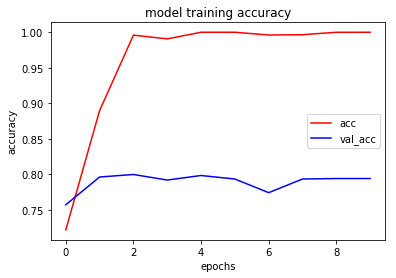

In [5]:
# load history dict from training
hist_dict = np.load('model/attn_hist_dict.npy').item()
plt.plot(hist_dict['acc'], 'red', label='acc')
plt.plot(hist_dict['val_acc'], 'blue', label='val_acc')
plt.title("model training accuracy")
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend(loc=7)
plt.show()

In [6]:
decoded = []

with open('result/attn_seq2seq.txt', 'w') as f:

    for sent_idx in range(len(x_test[:500])):

        this_txt = sequence.pad_sequences([x_test[sent_idx]], maxlen=MAX_INPUT, truncating='post', padding='post')
        this_pred = model.predict([this_txt])
        this_pred = [np.argmax(p) for p in this_pred[0]]

        word, tru, prd = [], [], []

        # for each word in the input sentence...
        for idx, wordid in enumerate(x_test[sent_idx]):
            word.append(idx2kor[wordid])
        # for each word in the true sentence...
        for idx, wordid in enumerate(y_test[sent_idx]):
            tru.append(idx2eng[wordid])
        # for each word in the output sentence...
        for idx, wordid in enumerate(this_pred):
            if wordid != 0:
                prd.append(idx2eng[wordid])

        f.write("IN : "+''.join(word)+'\n')
        f.write("TRU: "+''.join(tru)+'\n')
        f.write("PRD: "+''.join(prd)+'\n')
        f.write('\n')
        
        if sent_idx % 10 == 0:
            print("IN :", ''.join(word))
            print("TRU:", ''.join(tru))
            print("PRD:", ''.join(prd))
            print('')

       

IN : ㄷㅗㄹㄹㅣㅅㅕㅆㄴㅡㄴ
TRU: dollisyeossneun
PRD: eongeuyyossnen

IN : ㅈㅣㄹㄹㅓㅆㅅㅡㅂㄴㅣ
TRU: jilleossseubni
PRD: jijjeubyeobhi

IN : ㅈㅚㅇㅣㅁ
TRU: joeim
PRD: taiil

IN : ㅎㅡㄹㄹㅓㄴㅐㄹㅣ
TRU: heulleonaeli
PRD: kkeleonheoji

IN : ㅂㅡㄹㅏㅇㅜㄴ
TRU: beulaun
PRD: geuliun

IN : ㅈㅓㄹㄱㅕㅇ
TRU: jeolgyeong
PRD: seolmyeong

IN : ㅇㅘㄹㅗ
TRU: walo
PRD: aajo

IN : ㅅㅏㅁㅏㄱ
TRU: samag
PRD: banag

IN : ㅊㅣㄴㄱㅡㄴㅎㅏㄴ
TRU: chingeunhan
PRD: chengmmmhan

IN : ㅂㅜㄹㅡㅎㅡ
TRU: buleuheu
PRD: llleedeuu

IN : ㅍㅛㅎㅕㄴㅎㅏㄱㅣ
TRU: pyohyeonhagi
PRD: benyeonhagi

IN : ㅎㅢㅅㅐㅇㅎㅏㄷㅏ
TRU: huisaenghada
PRD: haensaaggha

IN : ㄷㅡㄹㅓㄴㅐㄱㅔ
TRU: deuleonaege
PRD: deuleonage

IN : ㄷㅓㄴㄷㅣ
TRU: deondi
PRD: deonsi

IN : ㅂㅜㄹㄱㅠㅊㅣㄱ
TRU: bulgyuchig
PRD: guleeucham

IN : ㄴㅗㅎㅇㅣ
TRU: nohi
PRD: nasi

IN : ㅈㅡㅇㅁㅕㅇㅎㅏㅈㅣ
TRU: jeungmyeonghaji
PRD: heungyonghagi

IN : ㅂㅏㄴㅅㅓㅇ
TRU: banseong
PRD: hobsyong

IN : ㅊㅚㅈㅏㅇㅅㅜ
TRU: choejangsu
PRD: cheonheso

IN : ㅌㅜㅊㅓㄱ
TRU: tucheog
PRD: becheog

IN : ㅌㅗㅂㄴㅠㅅㅡ
TRU: tobnyuseu
PRD: goleeuseu

IN : ㅁㅣㅇㅑㄴㅁㅏㅇㅓ
TRU: miyanmaeo
PRD: ganllalyo

IN : ㄷㅔㅇㅜㄹ
TRU: deul

In [ ]:
result = pd.concat(decoded)

In [ ]:
result

In [ ]:
# result.to_csv('wtf.csv')